# Rasterize the country polygons onto the population grid

> NOTE for future editions, the new netcdf grid version of the population file should include country identifiers already at the right resolution -> no need to rasterize separately for our modified population grid.

Project and rasterize the country polygons onto the population file grid, so that it can be used as a grid mask when doing the country specific calculations.

In [1]:
%matplotlib inline

import os

from pathlib import Path
from datetime import date

import rasterio
from rasterio import features
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import affine

from tqdm import tqdm_notebook
from shapely.geometry import Point
from descartes import PolygonPatch

import population_tools

from config import (DATA_SRC, POP_DATA_SRC, WEATHER_SRC)

In [28]:
RESULTS_FOLDER = DATA_SRC/ 'lancet/countries_rasters/'

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

# Define the countries that are in the European Union
# Don't forget to update post-Brexit >_<
COUNTRY_CODES_EU = ['AT',  'BE', 'BG', 'CY', 'CZ', 'DK', 'EE',
                    'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT', 'LV',
                    'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 
                    'SI', 'ES', 'SE', 'GB']


# LIMIT to the following countries for now
# SELECTED_COUNTRIES = ['IND', 'USA', 'GBR', 'FRA', 'SWE', 'AUS', 'BRA', 'CHN', 'CAN']
# SELECTED_COUNTRIES = ['IN', 'US', 'GB', 'FR', 'SW', 'AU', 'BR', 'CN', 'CA']

In [29]:
# Load a country shapefile for rasterising
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')

In [85]:
def rasterize_and_save_country(country_row, ref, out_folder, water_mask=None):
    # Identify country by commonly used 2-letter code.
    iso_a2 = country_row.iso_a2

    affine = population_tools.get_affine(ref)

    raster = features.rasterize(
        [(country_row.geometry, 1)],
        out_shape=ref.shape[:2],
        transform=affine,
        all_touched=True
    )
    # Roll the result to fix affine oddity
    raster = np.roll(raster, -raster.shape[1] // 2, axis=1)
    raster = raster * water_mask.squeeze().values
    raster.shape = (*raster.shape, 1)
    raster = xr.DataArray(raster, coords=[ref.latitude, ref.longitude, [iso_a2]], 
                        dims=['latitude', 'longitude', 'iso_a2'], name='country_mask')

    raster.to_netcdf(out_folder / f'country_{iso_a2}.nc')

    
# Initial method assigned the country ID code to each corresponding cell.
# However you have the issue of cells on the border - which country to assign to?
# Having all the different numbers also makes it harder to use the data as a boolean mask 
# (needs extra transform step) and to merge countries together.
# Instead create one grid per country and save as MF Dataset

# def rasterize_and_save_countries(pop, country_table, out_folder):           
#     countries = country_table[['geometry']].copy()
#     countries['iso_a3'] = country_table.index
    
#     raster = population_tools.rasterize_data(pop.population, countries, 'iso_a3')
#     raster = raster * pop.water_mask.squeeze().values
# #     raster.shape = (*raster.shape, 1)
#     raster = xr.DataArray(raster, coords=[pop.latitude, pop.longitude], 
#                         dims=['latitude', 'longitude'], name='country_id')
#     raster.to_netcdf(str(out_folder / 'country_all.nc'))

# with population_tools.load_masked_population(POP_FILE) as pop_file:
#     rasterize_and_save_countries(pop_file, COUNTRIES, RESULTS_FOLDER)

In [68]:
with population_tools.load_masked_population(POP_FILE) as pop_file:    
    for idx, row in tqdm_notebook(COUNTRIES.iterrows(), total=len(COUNTRIES)):
        rasterize_and_save_country(row, pop_file.population,
                                       RESULTS_FOLDER, pop_file.water_mask)

#### Also rasterize at the resolution of the climate data

In [32]:
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'ecmwf' / 'climatology_daily_tmin_quantiles.nc'

RESULTS_FOLDER_CLIM = DATA_SRC/ 'lancet/countries_climate_rasters/'
RESULTS_FOLDER_CLIM.mkdir(exist_ok=True)

In [40]:
def rasterize_to_climate_and_save_country(country_row, ref, out_folder):
    # Identify country by commonly used 2-letter code.
    iso_a2 = country_row.iso_a2

    affine = population_tools.get_affine(ref)

    raster = features.rasterize(
        [(country_row.geometry, 1)],
        out_shape=ref.shape[:2],
        transform=affine,
        all_touched=True
    )
    # Roll the result to fix affine oddity
    raster = np.roll(raster, -raster.shape[1] // 2, axis=1)
    
    raster.shape = (*raster.shape, 1)
    raster = xr.DataArray(raster, coords=[ref.latitude, ref.longitude, [iso_a2]], 
                        dims=['latitude', 'longitude', 'iso_a2'], name='country_mask')

    raster.to_netcdf(out_folder / f'country_{iso_a2}.nc')
    return raster

    
with xr.open_dataset(CLIMATOLOGY_DAILY_FILE) as ref_file:  
    
    ref = ref_file.sel(quantile=0.99, drop=True).temperature_2m
    
    for idx, row in tqdm_notebook(COUNTRIES.iterrows(), total=len(COUNTRIES)):
        r = rasterize_to_climate_and_save_country(row, ref,
                                       RESULTS_FOLDER_CLIM)

# Add the EU28 to the dataset as if it was a separate country

- Open the existing countries
- Select the EU countries by their ISO A2 code
- Flatten (using `any()` to select all points in iso_a2 dimension that are not null)
- Apply water mask
- Apply a simple circular mask to exclude overseas territories
- Save to results folder

In [26]:
iso_a2 = 'EU'
out_file = RESULTS_FOLDER / f'country_{iso_a2}.nc'
try:
    os.remove(out_file)
except FileNotFoundError:
    pass

with population_tools.load_masked_population(POP_FILE) as pop, \
      xr.open_mfdataset(str(RESULTS_FOLDER / 'country_*.nc')) as COUNTRIES_RASTER:

    # Create a simple circular mask over the EU which will exclude overseas territories, notably French Guyana
    # Create a circle around the 'centre of the EU https://en.wikipedia.org/wiki/Geographical_midpoint_of_Europe'
    # Rasterize the circle and use it to multiply the combined EU raster
    affine = population_tools.get_affine(pop.population)

    eu_mask = features.rasterize(
        [(Point(180+9.2477694, 50.1172861).buffer(30), 1)],
        out_shape=pop.population.shape[:2],
        transform=affine,
        all_touched=True
    )
    eu_mask = np.roll(eu_mask, -eu_mask.shape[1] // 2, axis=1)
   
    raster = (COUNTRIES_RASTER.sel(iso_a2=COUNTRY_CODES_EU)
                          .country_mask
                          .any(dim='iso_a2'))
    
    raster = raster *eu_mask * pop.water_mask.squeeze()
    
    raster = raster.expand_dims('iso_a2').transpose('latitude', 'longitude', 'iso_a2')
    raster = xr.DataArray(raster, coords=[pop.latitude, pop.longitude, [iso_a2]], 
                        dims=['latitude', 'longitude', 'iso_a2'], name='country_mask')
    
    raster.to_netcdf(out_file)

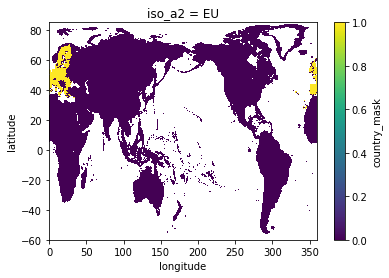

In [18]:
raster.plot()

In [44]:
# Repeat for the climate resolution data
iso_a2 = 'EU'
out_file = RESULTS_FOLDER_CLIM / f'country_{iso_a2}.nc'
try:
    os.remove(out_file)
except FileNotFoundError:
    pass

with xr.open_dataset(CLIMATOLOGY_DAILY_FILE) as ref_file, \
      xr.open_mfdataset(str(RESULTS_FOLDER_CLIM / 'country_*.nc')) as COUNTRIES_RASTER:

    ref = ref_file.sel(quantile=0.99, drop=True).temperature_2m
    
    # Create a simple circular mask over the EU which will exclude overseas territories, notably French Guyana
    # Create a circle around the 'centre of the EU https://en.wikipedia.org/wiki/Geographical_midpoint_of_Europe'
    # Rasterize the circle and use it to multiply the combined EU raster
    affine = population_tools.get_affine(ref)

    eu_mask = features.rasterize(
        [(Point(180+9.2477694, 50.1172861).buffer(30), 1)],
        out_shape=ref.shape[:2],
        transform=affine,
        all_touched=True
    )
    eu_mask = np.roll(eu_mask, -eu_mask.shape[1] // 2, axis=1)
   
    raster = (COUNTRIES_RASTER.sel(iso_a2=COUNTRY_CODES_EU)
                          .country_mask
                          .any(dim='iso_a2'))
    
    raster = raster * eu_mask
    
    raster = raster.expand_dims('iso_a2').transpose('latitude', 'longitude', 'iso_a2')
    raster = xr.DataArray(raster, coords=[ref.latitude, ref.longitude, [iso_a2]], 
                        dims=['latitude', 'longitude', 'iso_a2'], name='country_mask')
    
    raster.to_netcdf(out_file)

### Working used to figure out what mask to use to select only mainland EU

In [22]:
eu = COUNTRIES[COUNTRIES.iso_a2.isin(COUNTRY_CODES_EU)]
eu_clip = eu.drop('geometry', axis=1)

# buffer by 30degrees around the EU centre point.
eu_clip['geometry'] = eu.intersection(Point(180+9.2477694, 50.1172861).buffer(40))

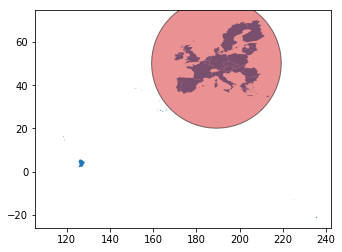

In [25]:
# Show that this clips out French Guyana
ax = eu.plot()
ax.add_patch(PolygonPatch( Point(180+9.2477694, 50.1172861).buffer(30) , fc='C3', alpha=0.5))

## Process EU from NUTS file

- Not currently used


In [69]:
# eu_nuts = gpd.read_file(str(DATA_SRC / 'GIS' / 'NUTS_2013_10M_SH' / 'data' / 'NUTS_RG_10M_2013.shp'))
# eu_nuts = eu_nuts[eu_nuts.STAT_LEVL_ == 0]

# # IMPORTANT! The EU country code is NOT always the same as the UN ISO code
# eu_nuts['iso_a2'] = eu_nuts.NUTS_ID

# EU_RESULTS_FOLDER = DATA_SRC/ 'lancet/eu_countries_rasters/'
# EU_RESULTS_FOLDER.mkdir(exist_ok=True)

In [11]:
# with population_tools.load_masked_population(POP_FILE) as pop_file:    
#     for idx, row in tqdm_notebook(eu_nuts.iterrows(), total=len(eu_nuts)):
#         rasterize_and_save_country(row, pop_file,
#                                        EU_RESULTS_FOLDER)
